In [1]:
pip install numpy pandas nltk tensorflow-cpu matplotlib  

     |████████████████████████████████| 221.4 MB 232 kB/s  eta 0:00:01   |████████▏                       | 56.1 MB 6.8 MB/s eta 0:00:25
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import random

2022-12-09 21:45:19.523203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## BBC News Summary EDA
TODO: add general description here

### Data preperation
To get started please paste the BBC news dataset into a folder titled data in the local directory. Then delete 199.txt in the articles and summaries directory respectively due to corruption with these files.

In [3]:
def get_text_by_topic(directory_path):
    data = []
    count = 0
    for topic in os.listdir(directory_path):
        topic_path = os.path.join(directory_path, topic)
        for file_path in os.listdir(topic_path):
            try:
                with open(f'{topic_path}/{file_path}', 'r', encoding="utf-8") as f:
                    data.append(( topic_path.split('/')[-1],f.read()))
                count+=1
            except UnicodeDecodeError:
                print(f'file {file_path} in {topic_path} is not readable')
                print(UnicodeDecodeError)
    df = pd.DataFrame(data, columns=['label','text'])
    print(f"Total Items loaded: {count}")
    return df
                      
articles_path = r"data/BBC News Summary/News Articles"
summaries_path = r"data/BBC News Summary/Summaries"

articles_df = get_text_by_topic(articles_path)
summaries_df = get_text_by_topic(summaries_path)
articles_df.head()

Total Items loaded: 2224
Total Items loaded: 2224


,label,text
0,business,Ad sales boost Time Warner profit\n\nQuarterly...
1,business,Dollar gains on Greenspan speech\n\nThe dollar...
2,business,Yukos unit buyer faces loan claim\n\nThe owner...
3,business,High fuel prices hit BA's profits\n\nBritish A...
4,business,Pernod takeover talk lifts Domecq\n\nShares in...


### Lets see an example from the dataset

In [4]:
print("Articles Shape: ",articles_df.shape)
print("Summaries Shape: ",summaries_df.shape)
# If this fails the wrong number of aricles or summaries was loaded
assert(articles_df.shape == summaries_df.shape)

ex_idx = int(random.random()*articles_df.shape[0])
ex_topic = articles_df["label"][ex_idx]
print(f"\nRandom Example Article in {ex_topic}:")
print(articles_df["text"][ex_idx])
print(f"Random Example Summary in {ex_topic}:")
print(summaries_df["text"][ex_idx])

Articles Shape:  (2224, 2)
Summaries Shape:  (2224, 2)

Random Example Article in business:
US firm pulls out of Iraq

A US company has pulled out of a major contract to rebuild Iraq's transport system after attacks on reconstruction efforts, Pentagon officials have said.

Contrack International, of Arlington, Virginia, heads a coalition of firms working on a series of schemes. Its withdrawal from the $325m (£170m) contract in November is thought to be the largest cancellation to date. Contrack said "the original scope of work that was envisioned could not be executed in a cost-effective manner". But the firm denied reports it was withdrawing completely from Iraq. "Members of the joint venture including Contrack are committed to the ongoing reconstruction efforts, are actively working in Iraq and continue to look for new construction opportunities in the country," it said in a statement. The Pentagon's Project and Contract Office (PCO) in Baghdad said it had taken over Contrack's manag

From this example we can see the dataset consists of BBC articles and co-responding summaries that are constructed in an extractive manner, that is, each summary is constructed by selecting a subset of the sentances in the original article.

In [5]:
# Null Checks
articles_df.isna().sum()
summaries_df.isna().sum()

label    0
text     0
dtype: int64

Next looking into the balance of each topic in the dataset

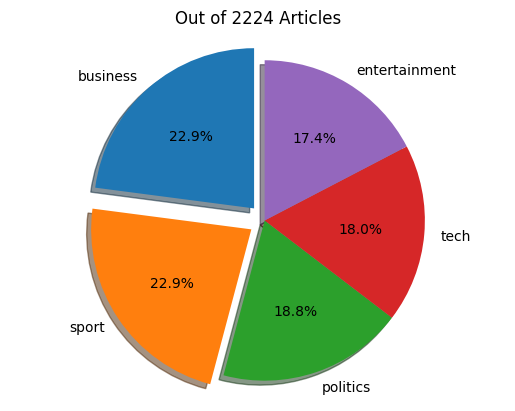

In [6]:
# Percent articles in each topic
label_vals = articles_df["label"].value_counts()

labels = list(label_vals.keys())
sizes = list(label_vals)
explode = [0]*len(sizes) 
explode[0] =0.1
explode[1] =0.1
fig1, ax1 = plt.subplots()
ax1.pie(label_vals, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(f"Out of {articles_df.shape[0]} Articles")
plt.show()


The classes appear to be well balance so model performance should be equivelent across topics

99th percentile in sentance count:  63.0


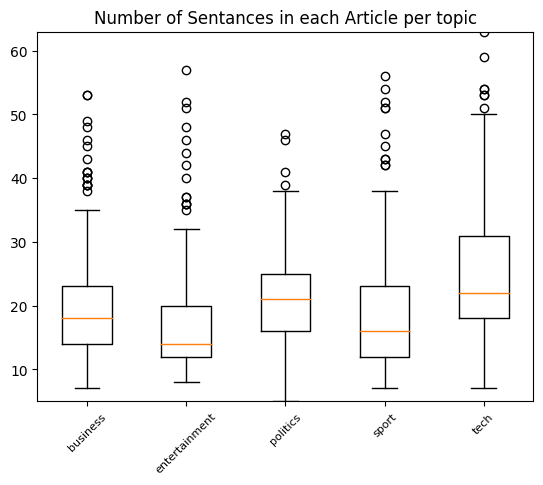

,business,entertainment,politics,sport,tech
count,510.000000,386.000000,417.000000,510.000000,401.000000
mean,19.680392,17.945596,22.227818,18.280392,25.842893
std,7.409560,14.270836,15.467658,9.876736,12.904370
min,7.000000,8.000000,5.000000,7.000000,7.000000
25%,14.000000,12.000000,16.000000,12.000000,18.000000
50%,18.000000,14.000000,21.000000,16.000000,22.000000
75%,23.000000,20.000000,25.000000,23.000000,31.000000
max,53.000000,205.000000,246.000000,82.000000,161.000000


In [7]:
# Number of Sentances in articles per topic
def get_text_length(daf, split):
    text_lens = [[len(t.split(split)) for t in daf["text"][daf['label'] == label]] for label in daf['label'].unique()]
    return text_lens

# Splitting on . for each sentance
text_lens = get_text_length(articles_df, ".")

t_lengths = pd.DataFrame(text_lens).transpose()
t_lengths.columns = articles_df['label'].unique()

# Outliars
print("99th percentile in sentance count: ",np.max(t_lengths.quantile(0.99)))

plt.boxplot(text_lens)
plt.title('Number of Sentances in each Article per topic')
plt.ylim(np.min(t_lengths.quantile(0)), np.max(t_lengths.quantile(0.99)))
plt.xticks([1,2,3,4,5],articles_df['label'].unique(),
                    rotation=45, fontsize=8)
plt.show()
t_lengths.describe()

It appears that tech articles have the longest articles in terms of sentances however the categories seem to be balanced here aswell. Noteably there are some drastic outliars for article length with 200+ sentances that may have to be removed.

99th percentile in Word count:  475.0


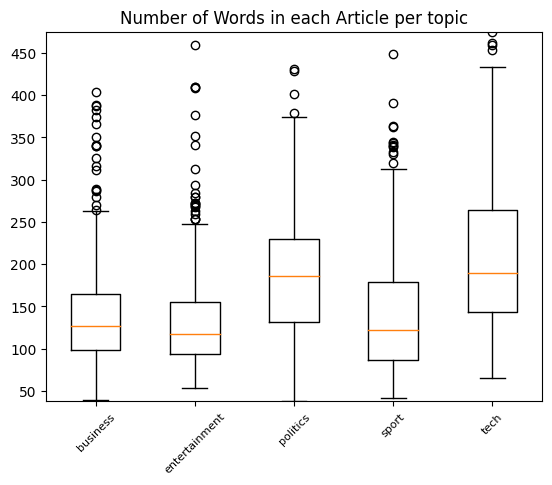

,business,entertainment,politics,sport,tech
count,510.00000,386.00000,417.000000,510.000000,401.000000
mean,139.94902,144.07772,195.738609,143.194118,213.880299
std,59.48480,124.31821,139.855957,80.966871,111.675336
min,40.00000,54.00000,38.000000,42.000000,65.000000
25%,99.00000,93.25000,132.000000,87.000000,144.000000
50%,127.00000,117.00000,186.000000,122.000000,189.000000
75%,164.75000,154.75000,230.000000,178.500000,264.000000
max,403.00000,1708.00000,2074.000000,659.000000,1433.000000


In [8]:
# Number of Words in articles per topic (splitting on " ")
text_lens = get_text_length(summaries_df, " ")

t_lengths = pd.DataFrame(text_lens).transpose()
t_lengths.columns = articles_df['label'].unique()

# Outliars
print("99th percentile in Word count: ",np.max(t_lengths.quantile(0.99)))

plt.boxplot(text_lens)
plt.title('Number of Words in each Article per topic')
plt.ylim(np.min(t_lengths.quantile(0)), np.max(t_lengths.quantile(0.99)))
plt.xticks([1,2,3,4,5],articles_df['label'].unique(),
                    rotation=45, fontsize=8)
plt.show()
t_lengths.describe()

Comparing the word counts to the sentance counts we can see the same outliar issue exists as well as sports having less words despite having more sentances implying that sentance length will vary based on the topic.

### Next looking at the ground truth reduction in word count

In [9]:
# Summary length reduction per topic by word count
articles_len = get_text_length(articles_df, " ")
summaries_len = get_text_length(summaries_df, " ")


# For each Topic
print("Average percent reduction in words for ...")
for i,topic in enumerate(articles_df['label'].unique()):
    # 1  - ratio of summary to article length
    avg_percent_reduction = np.mean(1-np.asarray(summaries_len[i])/np.asarray(articles_len[i]))
    print(f"{topic} summaries: {100*avg_percent_reduction:0.4f}%")

Average percent reduction in words for ...
business summaries: 56.8027%
entertainment summaries: 56.0781%
politics summaries: 56.5632%
sport summaries: 55.5133%
tech summaries: 57.2868%


From this we see across the board roughly half of the words are dropped in the ground truth summaries implying our model should have a similar dropout rate. This also may indicate classification may be a valid approach to determining whether a sentance should remain in the summary. Running this code over with sentance count reveals a similar trend implying no relationship between sentance length and likelyhood to be in the summmary.

### EDA with common heuristics in NLP

In extractive text summarization a common baseline model is to simply take the first few sentances (typically 3) of a peice of text as the summary as writers often introduce their main points in the beggining of articles. We will analyze the effectiveness of this heuristic for the BBC model for possible consideration for a baseline model

In [10]:
# For regular expression
import re
# for sentance parsing
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# turn each article into a list of sentances
def get_sentances(texts_list):
    documents = []
    for text in texts_list:
        documents.append(sent_tokenize(text.replace("\n\n",". ").replace(".. ",". ").replace(".",". ").replace(".  ",". ")))
    return documents
    #return [[a.strip() for a in t.replace("\n\n",".").split(".") if a!=''] for t in texts_list]

# First sentance inclusion in summary
article_sentances = get_sentances(articles_df["text"])
summary_sentances = get_sentances(summaries_df["text"])

# Check how many sentances (up to the fourth) of the article are in the summary
counts = [0]*4
for a,s in zip(article_sentances,summary_sentances):
    for i in range(len(counts)):
        if a[i+1] in s:
            counts[i]+=1
        else:
            break
print(f"{100*counts[0]/len(article_sentances):0.2f}% Article summaries include the first sentance of the article")
print(f"{100*counts[1]/len(article_sentances):0.2f}% Article summaries include the first and second")
print(f"{100*counts[2]/len(article_sentances):0.2f}% Article summaries include the first, second, and third")
print(f"{100*counts[3]/len(article_sentances):0.2f}% Article summaries include the first, second, third and fourth")

[nltk_data] Downloading package punkt to /home/nelly/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


69.83% Article summaries include the first sentance of the article
36.29% Article summaries include the first and second
17.81% Article summaries include the first, second, and third
7.33% Article summaries include the first, second, third and fourth


From this a good baseline model to compare text summarization would simply be to use the first few sentances of each article as the summary. The performance of this method is best with including one to two sentances

In [11]:
# Rarity of words used


In [12]:
# Overall use of stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Most common words after stop words

[nltk_data] Downloading package stopwords to /home/nelly/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
# Additional NLP statistics

## Base Line Model
From the EDA we found that an effective baseline model would be taking the first two sentances of the article as the predicted summary

In [14]:
# Each base line prediction is the first two sentaces of the article
def base_line_predict(articles_df):
    predictions = []
    article_sentances = get_sentances(articles_df["text"])
    for a in article_sentances:
        predictions.append(a[1:3])
    return predictions

pred = base_line_predict(articles_df)
print(f"Example baseline: {pred[0]}\n")
print(f"Example summary: {summary_sentances[0]}")

Example baseline: ['Quarterly profits at US media giant TimeWarner jumped 76% to $1.', '13bn (£600m) for the three months to December, from $639m year-earlier.']

Example summary: ['TimeWarner said fourth quarter sales rose 2% to $11.', '1bn from $10.', '9bn.', 'For the full-year, TimeWarner posted a profit of $3.', '36bn, up 27% from its 2003 performance, while revenues grew 6.', '4% to $42.', '09bn.', 'Quarterly profits at US media giant TimeWarner jumped 76% to $1.', '13bn (£600m) for the three months to December, from $639m year-earlier.', "However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues.", 'Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.', 'For 2005, TimeWarner is projecting operating earnings growth of around 5%, and also expects higher revenue and wider profit margins.', 'It lost 464,000 subscribers in the fourth quarter profits were

## Preprocessing For Extractive Text Summarization

In [15]:
from nltk.tokenize import word_tokenize
def compare_sentances(sentance_a, sentance_b):
    tok_a = word_tokenize(sentance_a)
    tok_b = word_tokenize(sentance_b)
    matches = 0
    for tok in tok_a:
        if tok in tok_b:
            matches+=1
    return float(matches)/len(tok_a)
    
# Generate Label
def generate_labels(articles_df, summaries_df):
    article_sentances = get_sentances(articles_df["text"])
    summary_sentances = get_sentances(summaries_df["text"])
    labels = []
    count=0
    total_sentances = 0
    same = 0
    for article,summary in zip(article_sentances,summary_sentances):
        sentance_inclusion = []
        for sentance_a in article:
            in_summary = False
            for sentance_b in summary:
                if len(sentance_b)<3:
                    continue
                percent_match = compare_sentances(sentance_a, sentance_b)
                if percent_match > 0.95:
                    in_summary=True
                    break
            total_sentances+=1
            if in_summary and len(sentance_a)>3:
                sentance_inclusion.append(1)
            else:
                sentance_inclusion.append(0)
        same+=np.sum(sentance_inclusion) == len(summary)
        count+=1
        print(f"Percent Complete: {100*count/len(article_sentances):0.2f}%",end="\r")
        labels.append(sentance_inclusion)
        
    print()
    print("Matching  labels ",same)
    print("Total ",len(article_sentances))
    print(f"Total Sentances processed {total_sentances}")
    return labels

#y_labels = generate_labels(articles_df, summaries_df) 

# Expand contractions
# lowercase
# Remove digits and words containing digits
# Remove punctuations
# Remove stop words

# Remove Contractions and other anomolies

# Vectorize sentance

## Extractive model based on single sentance analysis

In [16]:
article_sentances = get_sentances(articles_df["text"])
y_labels = generate_labels(articles_df, summaries_df) 

Percent Complete: 100.00%
Matching  labels  1867
Total  2224
Total Sentances processed 46905


In [17]:
import tensorflow as tf
#from tensorflow_models import nlp
from tensorflow.keras import layers
from tensorflow.keras import losses
from keras.utils import pad_sequences
import string 

def ex_standarize(input_txt):
  lowercase_txt = tf.strings.lower(input_txt)
  return tf.strings.regex_replace(lowercase_txt,'[%s]' % re.escape(string.punctuation),'')

max_features = 1000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=ex_standarize,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)


vectorize_layer.adapt(articles_df["text"])

all_sentances = []
all_labels = []

for i in range(len(article_sentances)):
    for j in range(len(article_sentances[i])):
        all_sentances.append(article_sentances[i][j])
        all_labels.append(y_labels[i][j])

x_train = vectorize_layer(all_sentances)
y_train = np.asarray(all_labels)
print(f"There are {len(x_train)} sentances in total")
print(f"Vecorized sentance sample: {x_train[1][:10]}")
print(f"Corresponding label: {y_train[1]}")

2022-12-09 21:47:30.492699: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


There are 46905 sentances in total
Vecorized sentance sample: [  1 624  21  48 284 679   1   1   1   3]
Corresponding label: 1


In [18]:
embedding_dim = 32
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.Conv1D(128, 7, padding="valid", activation="relu", strides=2),
  layers.Conv1D(128, 7, padding="valid", activation="relu", strides=2),
  layers.GlobalAveragePooling1D(),
  layers.Dense(128, activation="relu"),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          32032     
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         28800     
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         114816    
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                        

In [19]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [20]:
from sklearn.model_selection import train_test_split
# 80 10 10 split for training validation test
X_train, X_test, Y_train, Y_test = train_test_split(x_train.numpy(), y_train, test_size=0.2,shuffle=True,random_state=41)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=41)

epochs = 20
print(x_train.shape)
history = model.fit(x_train,y_train, validation_data=(X_valid, Y_valid),epochs=epochs,batch_size =32)


(46905, 250)
Epoch 1/20
1466/1466 [==============================] - 25s 17ms/step - loss: 0.6200 - binary_accuracy: 0.6558 - val_loss: 0.5841 - val_binary_accuracy: 0.6925
Epoch 2/20
1466/1466 [==============================] - 24s 16ms/step - loss: 0.5925 - binary_accuracy: 0.6820 - val_loss: 0.5754 - val_binary_accuracy: 0.7109
Epoch 3/20
1466/1466 [==============================] - 24s 16ms/step - loss: 0.5798 - binary_accuracy: 0.6937 - val_loss: 0.5491 - val_binary_accuracy: 0.7175
Epoch 4/20
1466/1466 [==============================] - 32s 22ms/step - loss: 0.5644 - binary_accuracy: 0.7055 - val_loss: 0.5285 - val_binary_accuracy: 0.7401
Epoch 5/20
1466/1466 [==============================] - 37s 26ms/step - loss: 0.5472 - binary_accuracy: 0.7165 - val_loss: 0.5055 - val_binary_accuracy: 0.7586
Epoch 6/20
1466/1466 [==============================] - 31s 21ms/step - loss: 0.5303 - binary_accuracy: 0.7282 - val_loss: 0.4741 - val_binary_accuracy: 0.7725
Epoch 7/20
1466/1466 [=====

In [21]:
print(history.history)

{'loss': [0.6200245022773743, 0.5925460457801819, 0.5798472762107849, 0.5644118189811707, 0.5471779108047485, 0.5302600264549255, 0.5125654339790344, 0.4954492747783661, 0.47995999455451965, 0.4639177918434143, 0.4491404592990875, 0.4363623857498169, 0.4184128940105438, 0.40516984462738037, 0.3926365077495575, 0.3751983344554901, 0.36433520913124084, 0.3535001277923584, 0.340719074010849, 0.3266104757785797], 'binary_accuracy': [0.655836284160614, 0.6819742321968079, 0.6937426924705505, 0.705468475818634, 0.7165334224700928, 0.728195309638977, 0.7432256937026978, 0.7545890808105469, 0.762690544128418, 0.7729666233062744, 0.784116804599762, 0.7917919158935547, 0.8029847741127014, 0.810105562210083, 0.8163948655128479, 0.8280566930770874, 0.8341968059539795, 0.8394840359687805, 0.8450911641120911, 0.8546210527420044], 'val_loss': [0.584070086479187, 0.5754242539405823, 0.5490711331367493, 0.5285032391548157, 0.5054962635040283, 0.47412508726119995, 0.4565580189228058, 0.43198615312576294

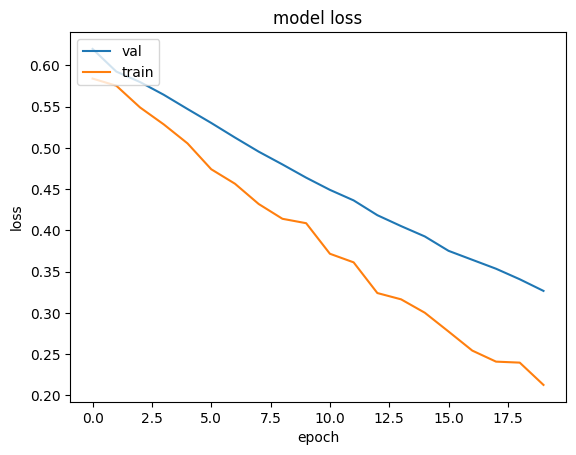

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val', 'train'], loc='upper left')
plt.show()

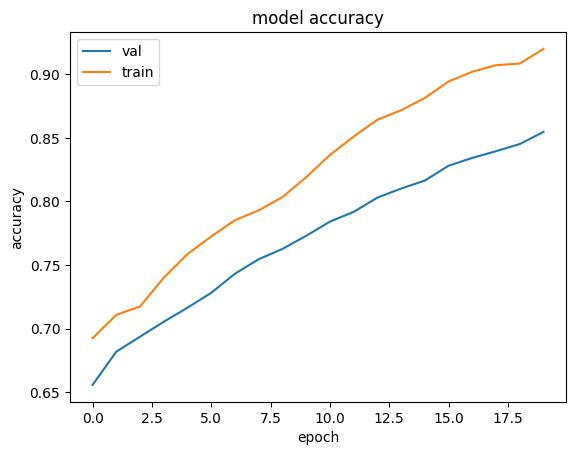

In [23]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val','train',], loc='upper left')
plt.show()

In [24]:
# reconstruct summaries
# All predicted summaries is a list for each article where each entry is a list of summary sentances
all_predicted_summaries = []
for i in range(len(article_sentances)):
    model_predictions = model.predict(vectorize_layer(article_sentances[i]),verbose = 0)
    model_predictions = np.where(model_predictions>0.5,1,0)
    summary = []
    for j in range(len(article_sentances[i])):
        if model_predictions[j]==1:
            summary.append(article_sentances[i][j])
    all_predicted_summaries.append(summary)
    print(f"Percentage Complete: {100*i/len(article_sentances):0.2f}%",end="\r")
print()

Percentage Complete: 99.96%


In [25]:
print(all_predicted_summaries[400])
out = ""
for s in all_predicted_summaries[400]:
    out+=s
print(out)
print(summaries_df["text"][400])

['An executive at US insurance firm Marsh & McLennan has pleaded guilty to criminal charges in connection with an ongoing fraud and bid-rigging probe.', "Mr Spitzer's office added Mr Stearns had also agreed to testify in future cases during the industry inquiry.", "According to a statement from Mr Spitzer's office, the Marsh executive admitted he instructed insurance companies to submit non-competitive bids for insurance business between 2002 and 2004.", "Through the practice, Marsh was allowed to determine which insurers won business from clients, and so control the insurance market, Mr Spitzer's office added.", 'It also protected incumbent insurers when their business was up for renewal and helped Marsh to maximise its fees, a statement said.']
An executive at US insurance firm Marsh & McLennan has pleaded guilty to criminal charges in connection with an ongoing fraud and bid-rigging probe.Mr Spitzer's office added Mr Stearns had also agreed to testify in future cases during the indu

## Preprocessing For Abstractive Text Summarization

In [26]:
# Import tokenizer from pretrained model
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "t5-small" # you can specify the model size here
tokenizer = AutoTokenizer.from_pretrained(model_name)

/home/nelly/.local/share/virtualenvs/Fall-U4moqXgd/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Downloading: 100%|██████████████████████████████████████████████████████████████████| 1.20k/1.20k [00:00<00:00, 283kB/s]
Downloading: 100%|███████████████████████████████████████████████████████████████████| 792k/792k [00:00<00:00, 5.17MB/s]
Downloading: 100%|█████████████████████████████████████████████████████████████████| 1.39M/1.39M [00:00<00:00, 7.02MB/s]
/home/nelly/.local/share/virtualenvs/Fall-U4moqXgd/lib/python3.8/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/en

In [27]:
MAX_INPUT_LENGTH = 512
MAX_TARGET_LENGTH = 30

def preprocess_function(article, summary):
    model_inputs = tokenizer(
        article,
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
    )
    labels = tokenizer(
        summary, max_length=MAX_TARGET_LENGTH, truncation=True
    )
    #model_inputs["labels"] = articles["labels"]
    return model_inputs

for i in range(articles_df.shape[0]):
    result = preprocess_function(articles_df["text"][0], summaries_df["text"][0])